## Setup in Colab

### Install and load dataset

In [1]:
!pip install nvidia-nvimgcodec-cu11 opencv-python-headless
!git clone https://github.com/EliSchwartz/imagenet-sample-images.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 33.3 MB/s eta 0:00:00
Cloning into 'imagenet-sample-images'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1012 (delta 3), reused 5 (delta 2), pack-reused 1002 (from 1)
Receiving objects: 100% (1012/1012), 103.84 MiB | 20.10 MiB/s, done.
Resolving deltas: 100% (3/3), done.


### Prepare the 1000 JPEGs

In [2]:
import os, shutil
from pathlib import Path

source_dir = Path("imagenet-sample-images")
dest_dir = Path("benchmark_images")
dest_dir.mkdir(exist_ok=True)

all_images = list(source_dir.glob("*.JPEG"))
for img in all_images:
    shutil.copy(img, dest_dir / img.name)

image_paths = sorted(list(dest_dir.glob("*.JPEG")))
print(f"Prepared {len(image_paths)} images.")


Prepared 1000 images.


### Model and preprocessing

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import Resize, CenterCrop

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True).to(device).eval()

transform = transforms.Compose([
    Resize(256),
    CenterCrop(224),
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


## Benchmark Functions (10x Repeated Runs)

### OpenCV

In [5]:
def run_opencv_inference(image_paths, runs=10):
    import time, numpy as np
    from PIL import Image

    load_times, infer_times = [], []
    for run_idx in range(runs + 1):
        imgs = []
        t0 = time.time()
        for path in image_paths:
            img = cv2.imread(str(path))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img)
            img = transform(img)
            img = transforms.ToTensor()(img)
            imgs.append(img)
        batch = torch.stack(imgs).to(device)
        load_time = time.time() - t0

        t1 = time.time()
        with torch.no_grad():
            model(batch)
        infer_time = time.time() - t1

        if run_idx == 0:
            print(f"Run {run_idx + 1}: Warmup iteration (not included in mean). Loading Time = {load_time:.4f}s, Inference Time = {infer_time:.4f}s")
        else:
            load_times.append(load_time)
            infer_times.append(infer_time)
            print(f"Run {run_idx + 1}: Loading Time = {load_time:.4f}s, Inference Time = {infer_time:.4f}s")

    return np.mean(load_times), np.mean(infer_times)

opencv_load, opencv_infer = run_opencv_inference(image_paths)

Run 1: Warmup iteration (not included in mean). Loading Time = 12.0093s, Inference Time = 0.1995s
Run 2: Loading Time = 7.1397s, Inference Time = 0.0037s
Run 3: Loading Time = 6.0451s, Inference Time = 0.0041s
Run 4: Loading Time = 5.8159s, Inference Time = 0.0035s
Run 5: Loading Time = 5.5145s, Inference Time = 0.0040s
Run 6: Loading Time = 6.1096s, Inference Time = 0.0033s
Run 7: Loading Time = 5.4692s, Inference Time = 0.0034s
Run 8: Loading Time = 6.2693s, Inference Time = 0.0033s
Run 9: Loading Time = 5.6876s, Inference Time = 0.0033s
Run 10: Loading Time = 7.2034s, Inference Time = 0.0032s
Run 11: Loading Time = 5.5801s, Inference Time = 0.0033s


### nvImageCodec



In [6]:
def run_nvimagecodec_inference(image_paths, runs=10):
    import time, numpy as np
    decoder = nvimgcodec.Decoder(device_id=0)

    load_times, infer_times = [], []
    for run_idx in range(runs + 1):
        imgs = []
        t0 = time.time()
        for path in image_paths:
            with open(path, 'rb') as f:
                data = f.read()
            nv_img = decoder.decode(data)
            img = torch.as_tensor(nv_img.cuda()).permute(2, 0, 1).float().div(255)
            img = transform(img)
            imgs.append(img)
        batch = torch.stack(imgs).to(device)
        load_time = time.time() - t0

        t1 = time.time()
        with torch.no_grad():
            model(batch)
        infer_time = time.time() - t1

        if run_idx == 0:
            print(f"Run {run_idx + 1}: Warmup iteration (not included in mean). Loading Time = {load_time:.4f}s, Inference Time = {infer_time:.4f}s")
        else:
            load_times.append(load_time)
            infer_times.append(infer_time)
            print(f"Run {run_idx + 1}: Loading Time = {load_time:.4f}s, Inference Time = {infer_time:.4f}s")

    return np.mean(load_times), np.mean(infer_times)

nv_load, nv_infer = run_nvimagecodec_inference(image_paths)

Run 1: Warmup iteration (not included in mean). Loading Time = 3.2164s, Inference Time = 0.0031s
Run 2: Loading Time = 2.7221s, Inference Time = 0.0033s
Run 3: Loading Time = 2.7256s, Inference Time = 0.0031s
Run 4: Loading Time = 2.7249s, Inference Time = 0.0030s
Run 5: Loading Time = 3.1691s, Inference Time = 0.0031s
Run 6: Loading Time = 2.7240s, Inference Time = 0.0032s
Run 7: Loading Time = 2.6791s, Inference Time = 0.0030s
Run 8: Loading Time = 2.6770s, Inference Time = 0.0031s
Run 9: Loading Time = 2.9651s, Inference Time = 0.0040s
Run 10: Loading Time = 2.7355s, Inference Time = 0.0033s
Run 11: Loading Time = 2.7040s, Inference Time = 0.0031s


## Results & Visualization

         Method  Loading Time (s)  Inference Time (s)  Total Time (s)
0        OpenCV          6.083434            0.003495        6.086930
1  nvImageCodec          2.782621            0.003231        2.785852


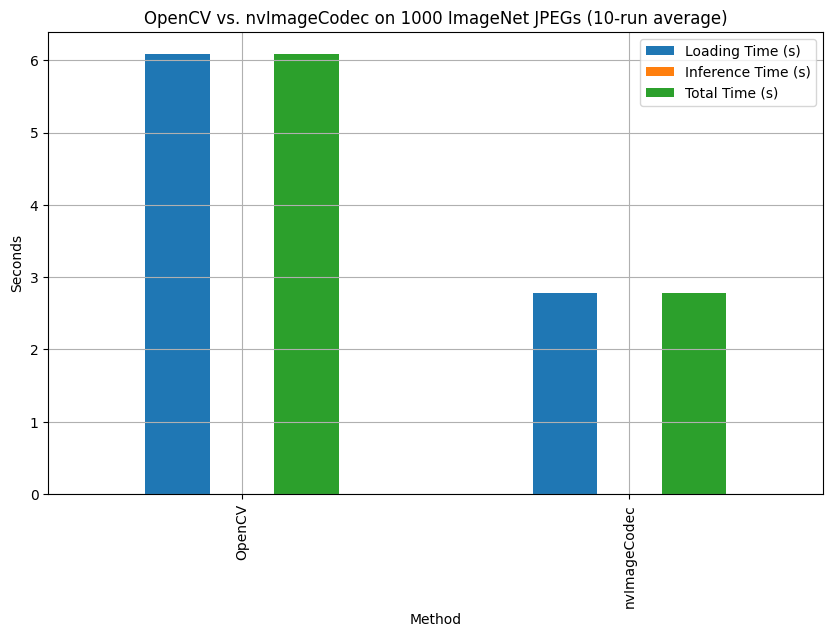

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

results = pd.DataFrame({
    "Method": ["OpenCV", "nvImageCodec"],
    "Loading Time (s)": [opencv_load, nv_load],
    "Inference Time (s)": [opencv_infer, nv_infer],
    "Total Time (s)": [
        opencv_load + opencv_infer,
        nv_load + nv_infer
    ],
})

print(results)

results.plot(x="Method", y=["Loading Time (s)", "Inference Time (s)", "Total Time (s)"],
             kind="bar", figsize=(10, 6))
plt.title("OpenCV vs. nvImageCodec on 1000 ImageNet JPEGs (10-run average)")
plt.ylabel("Seconds")
plt.grid(True)
plt.show()
